# 03 - Entrenamiento y Evaluación de Modelos con Pipelines

**Objetivo:** En este notebook, se entrenan y evalúan los modelos de clasificación utilizando `Pipelines` de Scikit-learn para un flujo de trabajo más limpio, robusto y profesional.

## 1. Carga de Datos y Librerías
Importamos todas las librerías y cargamos los conjuntos de datos preprocesados.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import numpy as np

# Librerías de Scikit-learn y Imbalanced-learn
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline especial para samplers como SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Carga los datos preprocesados
datos = load('../data/processed/cicids2017_preprocessed_data.joblib')

X_train_scaled = datos['X_train_scaled']
X_test_scaled = datos['X_test_scaled']
y_train = datos['y_train']
y_test = datos['y_test']

print("Datos cargados exitosamente.")

Datos cargados exitosamente.


## 2. Experimento 1: Pipeline con Regresión Logística (Baseline)
Creamos y evaluamos nuestro modelo base. El pipeline por ahora solo contiene el clasificador, ya que los datos ya están escalados.

Entrenando Pipeline de Regresión Logística...

--- Reporte de Clasificación (Regresión Logística) ---


c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

                          precision    recall  f1-score   support

                  BENIGN       0.98      0.98      0.98    681396
                     Bot       0.93      0.02      0.05       587
                    DDoS       0.91      0.99      0.95     38408
           DoS GoldenEye       0.93      0.74      0.82      3088
                DoS Hulk       0.98      0.87      0.92     69037
        DoS Slowhttptest       0.87      0.77      0.81      1650
           DoS slowloris       0.89      0.47      0.61      1739
             FTP-Patator       0.96      0.33      0.49      2380
              Heartbleed       0.43      1.00      0.60         3
            Infiltration       0.14      0.09      0.11        11
                PortScan       0.81      1.00      0.89     47641
             SSH-Patator       0.94      0.51      0.66      1769
  Web Attack Brute Force       0.00      0.00      0.00       452
Web Attack Sql Injection       0.00      0.00      0.00         6
         

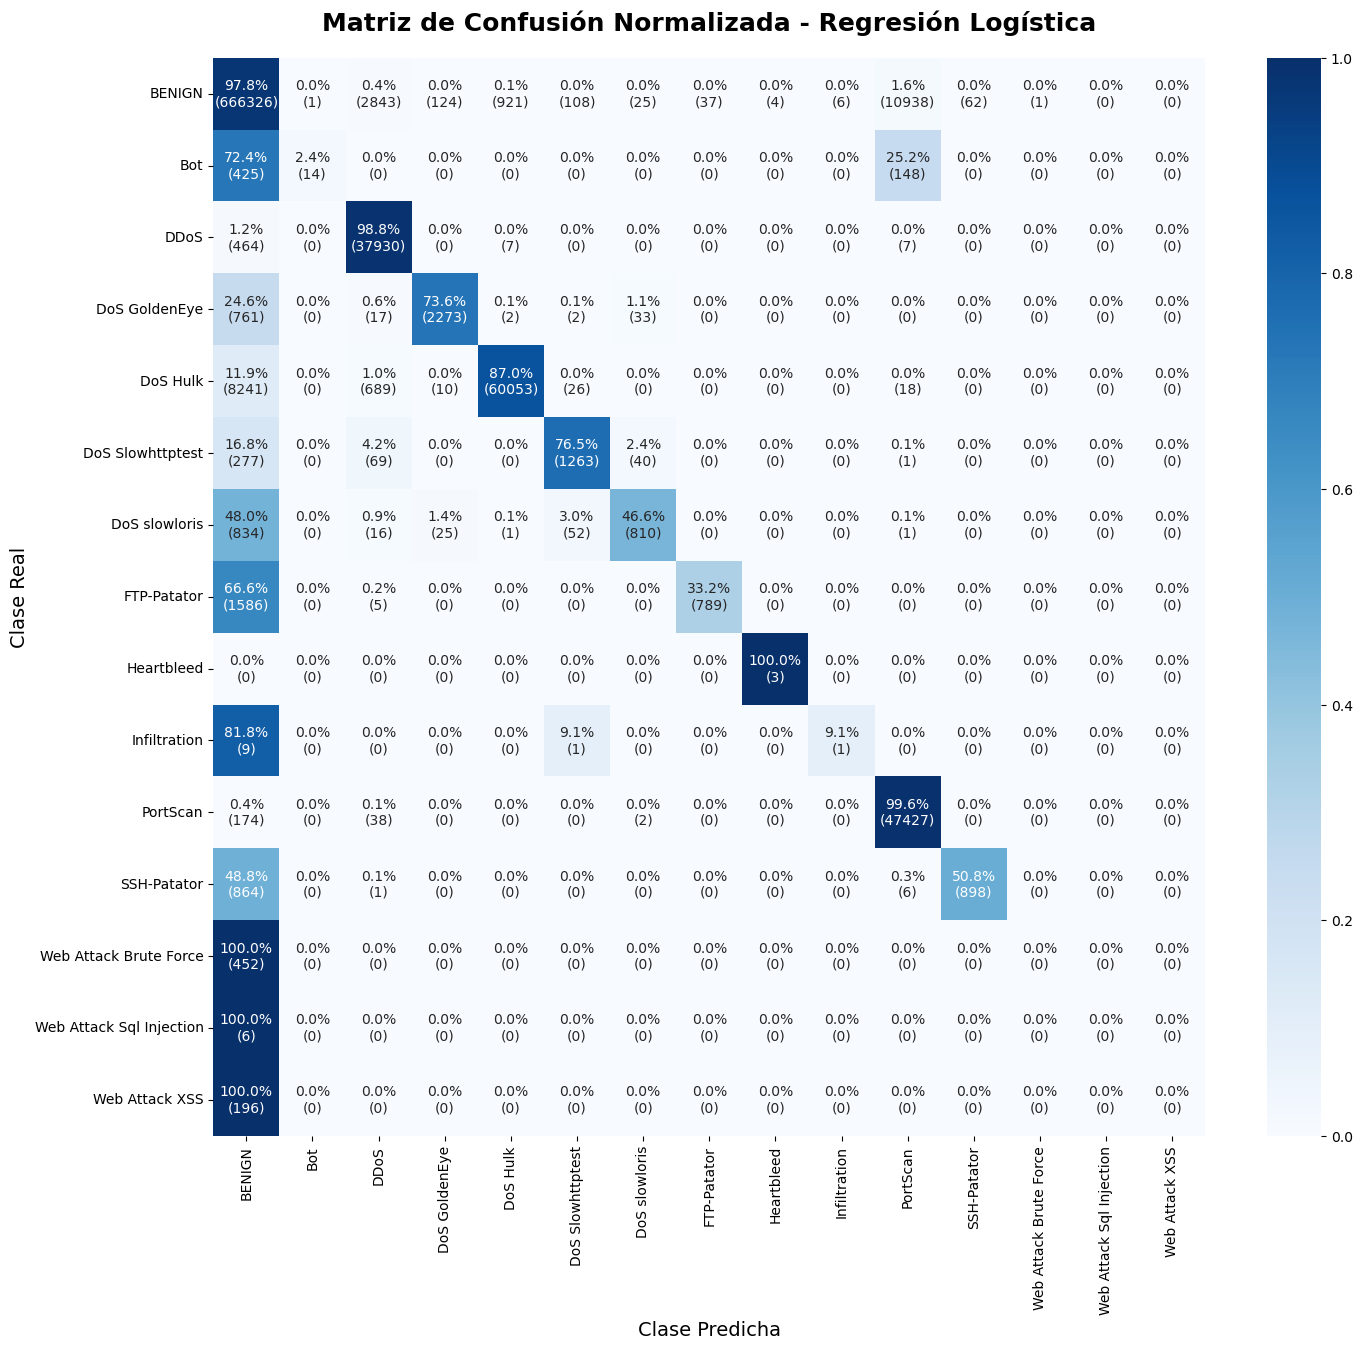

In [4]:
# Definir el pipeline
pipeline_lr = Pipeline([
    ('classifier', LogisticRegression(random_state = 42, n_jobs = -1, max_iter = 1000))
])

# Entrenar
print("Entrenando Pipeline de Regresión Logística...")
pipeline_lr.fit(X_train_scaled, y_train)

# Evaluar con Reporte de Clasificación
print("\n--- Reporte de Clasificación (Regresión Logística) ---")
y_pred_lr = pipeline_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))

# Analizar Errores con Matriz de Confusión Estilizada
print("\n--- Matriz de Confusión (Regresión Logística) ---")
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Normalizamos la matriz por fila para ver los porcentajes de 'recall'
cm_normalized = cm_lr.astype('float') / cm_lr.sum(axis = 1)[:, np.newaxis]

# Creamos etiquetas que combinen porcentaje y número absoluto
labels = (np.asarray(["{0:.1%}\n({1})".format(pct, count) 
                      for pct, count in zip(cm_normalized.flatten(), cm_lr.flatten())])
         ).reshape(cm_lr.shape)

# Visualizamos con los nuevos parámetros
plt.figure(figsize = (16, 14))
sns.heatmap(cm_normalized, 
            annot = labels, 
            fmt = '', 
            cmap = 'Blues',
            xticklabels = pipeline_lr.classes_, 
            yticklabels = pipeline_lr.classes_)
plt.title('Matriz de Confusión Normalizada - Regresión Logística', fontsize = 18, fontweight = 'bold', pad = 20)
plt.ylabel('Clase Real', fontsize = 14)
plt.xlabel('Clase Predicha', fontsize = 14)
plt.show()

### Análisis de Resultados (Regresión Logística)

El reporte de clasificación y la matriz de confusión para nuestro modelo base de Regresión Logística muestran un rendimiento mixto, fuertemente influenciado por el desbalance de clases del dataset.

#### Fortalezas
* El modelo es **excelente para identificar el tráfico `BENIGN`**, con un `recall` del **97.9%**.
* También es muy efectivo para detectar los ataques más comunes, como **`DDoS` (98.8% de recall)** y **`PortScan` (99.6% de recall)**. Prácticamente no deja pasar ninguno de estos ataques.

#### Debilidades
La matriz de confusión normalizada revela el problema de las clases minoritarias con gran claridad:
* **Fallo Total:** Para las tres clases de **`Web Attack`**, el `recall` es del **0.0%**. La matriz muestra que el **100%** de estos ataques fueron incorrectamente clasificados como `BENIGN`.
* **Confusión Generalizada con `BENIGN`:** Este patrón de error se repite en casi todas las clases débiles. Por ejemplo:
    * El modelo solo detecta el **2.4%** de los ataques de `Bot`, confundiendo el **72.4%** de ellos con tráfico `BENIGN`.
    * Solo detecta el **33.2%** de los `FTP-Patator`, confundiendo el **66.6%** con `BENIGN`.
    * El `recall` de `Infiltration` es de solo **9.1%**, con un **81.8%** de los casos clasificados erróneamente como `BENIGN`.

#### Conclusión General
El modelo base de Regresión Logística está severamente **sesgado hacia la clase mayoritaria**. Su estrategia principal ante la duda es predecir `BENIGN`. Aunque es efectivo para los ataques más comunes, es completamente inútil para detectar ataques raros. Nuestro objetivo con los siguientes modelos será mejorar drásticamente estas métricas de `recall`.

## 3. Experimento 2: Pipeline con Random Forest
Ahora probamos con el modelo más avanzado sobre los datos desbalanceados.

Entrenando Pipeline de Random Forest...

--- Reporte de Clasificación (Random Forest) ---
                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00    681396
                     Bot       0.84      0.78      0.81       587
                    DDoS       1.00      1.00      1.00     38408
           DoS GoldenEye       1.00      0.99      0.99      3088
                DoS Hulk       1.00      1.00      1.00     69037
        DoS Slowhttptest       0.99      0.99      0.99      1650
           DoS slowloris       1.00      1.00      1.00      1739
             FTP-Patator       1.00      1.00      1.00      2380
              Heartbleed       1.00      1.00      1.00         3
            Infiltration       1.00      0.64      0.78        11
                PortScan       0.99      0.99      0.99     47641
             SSH-Patator       1.00      1.00      1.00      1769
  Web Attack Brute Force       0.74      0.74      

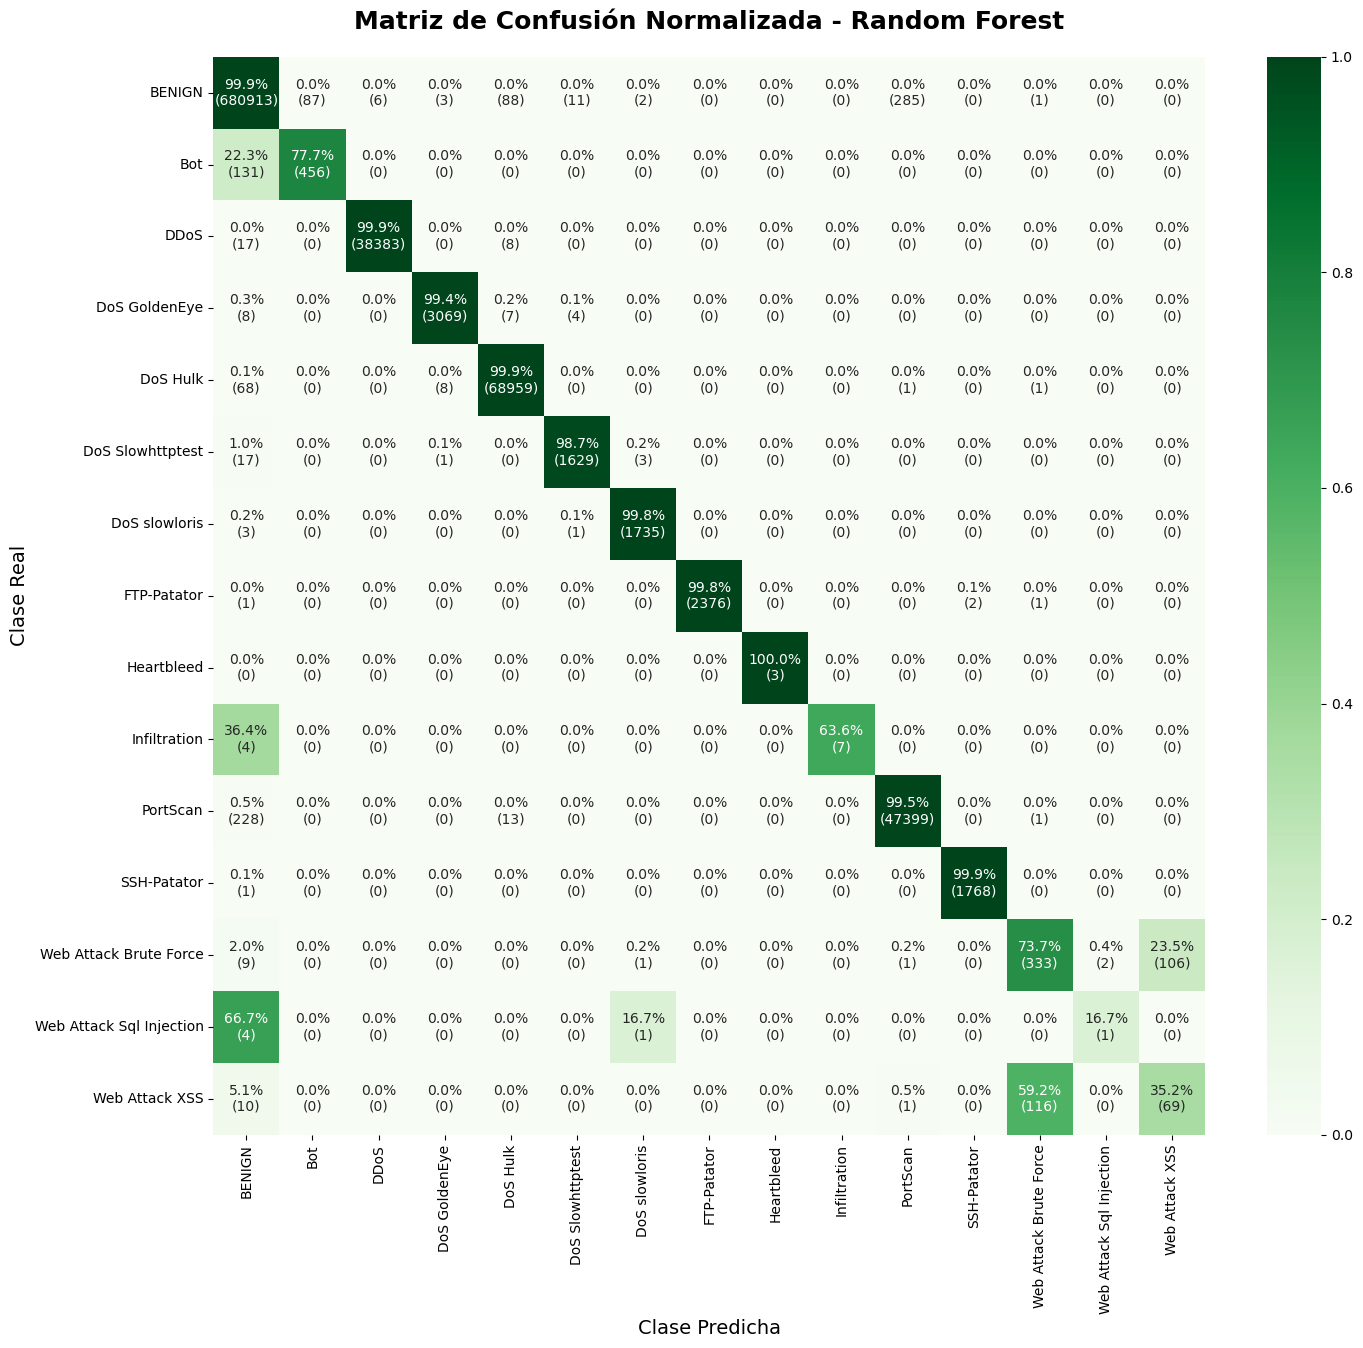

In [5]:
# Definir el pipeline
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))
])

# Entrenar
print("Entrenando Pipeline de Random Forest...")
pipeline_rf.fit(X_train_scaled, y_train)

# Evaluar con Reporte de Clasificación
print("\n--- Reporte de Clasificación (Random Forest) ---")
y_pred_rf = pipeline_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))

# Analizar Errores con Matriz de Confusión Estilizada
print("\n--- Matriz de Confusión (Random Forest) ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_normalized = cm_rf.astype('float') / cm_rf.sum(axis = 1)[:, np.newaxis]
labels = (np.asarray(["{0:.1%}\n({1})".format(pct, count) 
                      for pct, count in zip(cm_normalized.flatten(), cm_rf.flatten())])
         ).reshape(cm_rf.shape)

plt.figure(figsize = (16, 14))
sns.heatmap(cm_normalized, 
            annot = labels, 
            fmt = '', 
            cmap = 'Greens',
            xticklabels = pipeline_rf.classes_, 
            yticklabels = pipeline_rf.classes_)
plt.title('Matriz de Confusión Normalizada - Random Forest', fontsize = 18, fontweight = 'bold', pad = 20)
plt.ylabel('Clase Real', fontsize = 14)
plt.xlabel('Clase Predicha', fontsize = 14)
plt.show()

### Análisis de Resultados (Random Forest)

El `RandomForestClassifier` ofrece una mejora drástica en el rendimiento en comparación con el modelo base. La matriz de confusión normalizada revela avances significativos, especialmente en la detección de clases minoritarias.

#### Hallazgos Clave:

* **Reducción Drástica de Errores:** El modelo ha reducido masivamente la confusión principal que tenía la Regresión Logística (predecir `BENIGN` incorrectamente).
    * El `recall` de **`Bot`** saltó de un 2.4% a un **77.7%**. La matriz muestra que la confusión con `BENIGN` se redujo de un 72.4% a solo un 22.3%.
    * Las clases de **`Web Attack`**, que antes tenían un 0% de `recall`, ahora son detectadas. Por ejemplo, `Web Attack Brute Force` ahora se detecta correctamente el **73.7%** de las veces.

* **Nuevo Hallazgo: Confusión entre Ataques Similares:**
    La matriz revela un nuevo patrón de error más sutil. El modelo ahora confunde los subtipos de `Web Attack` entre sí.
    * El **59.2%** de los ataques `Web Attack XSS` fueron incorrectamente etiquetados como `Web Attack Brute Force`.
    * A su vez, el **23.5%** de los `Web Attack Brute Force` fueron confundidos con `Web Attack XSS`.
    Esto indica que el modelo sabe que es un "ataque web", pero le cuesta diferenciar los matices entre ellos.

* **Advertencia de Sobreajuste (Overfitting):**
    La `accuracy` general de 1.00 y los `recall` perfectos en muchas clases son una señal de posible sobreajuste. El modelo podría estar "memorizando" los datos de entrenamiento.

#### Conclusión General
El Random Forest es un modelo inmensamente superior al baseline. Ha solucionado en gran medida el problema del sesgo hacia la clase `BENIGN`. Su principal debilidad ahora es la dificultad para diferenciar entre ataques muy similares y su bajo rendimiento en clases con soporte extremadamente bajo (como `Web Attack Sql Injection`).

El siguiente paso es aplicar SMOTE para ver si, al darle más ejemplos sintéticos, podemos ayudar al modelo a aprender mejor estas diferencias sutiles.

## 4. Experimento 3: Pipeline con SMOTE y Random Forest
Finalmente, construimos un pipeline que primero balancea los datos de entrenamiento con SMOTE y luego entrena el Random Forest. Usamos el `Pipeline` de la librería `imbalanced-learn` que está diseñado para manejar esto correctamente.

Entrenando Pipeline con SMOTE y Random Forest...


c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Exception in thread Thread-35 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\threading.py", line 98


--- Reporte de Clasificación (Random Forest con SMOTE) ---
                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00    681396
                     Bot       0.69      0.95      0.80       587
                    DDoS       1.00      1.00      1.00     38408
           DoS GoldenEye       0.99      1.00      0.99      3088
                DoS Hulk       1.00      1.00      1.00     69037
        DoS Slowhttptest       0.97      0.99      0.98      1650
           DoS slowloris       1.00      0.98      0.99      1739
             FTP-Patator       1.00      1.00      1.00      2380
              Heartbleed       1.00      1.00      1.00         3
            Infiltration       1.00      0.73      0.84        11
                PortScan       0.99      1.00      1.00     47641
             SSH-Patator       1.00      1.00      1.00      1769
  Web Attack Brute Force       0.73      0.61      0.67       452
Web Attack Sql 

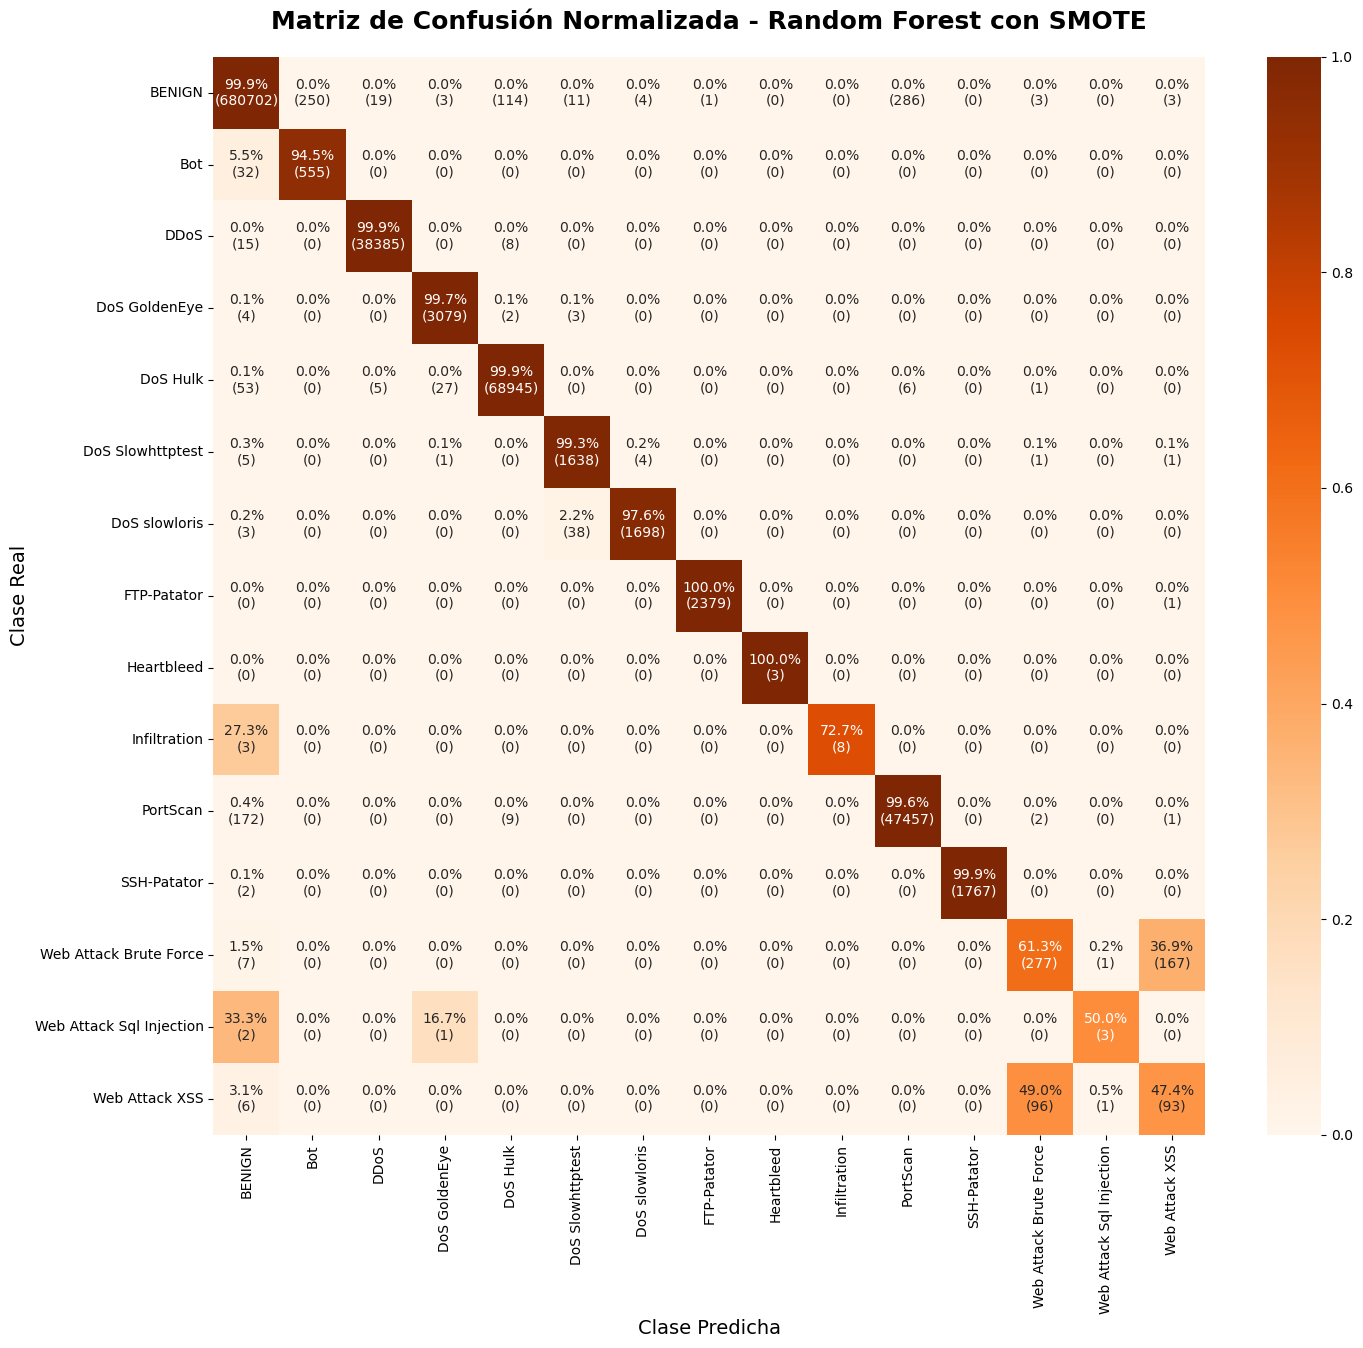

In [6]:
# Definir el pipeline especial de imblearn
pipeline_smote_rf = ImbPipeline([
    ('smote', SMOTE(random_state = 42)),
    ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))
])

# Entrenar
print("Entrenando Pipeline con SMOTE y Random Forest...")
pipeline_smote_rf.fit(X_train_scaled, y_train)

# Evaluar con Reporte de Clasificación
print("\n--- Reporte de Clasificación (Random Forest con SMOTE) ---")
y_pred_smote_rf = pipeline_smote_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_smote_rf))

# Analizar Errores con Matriz de Confusión Estilizada
print("\n--- Matriz de Confusión (Random Forest con SMOTE) ---")
cm_smote_rf = confusion_matrix(y_test, y_pred_smote_rf)
cm_normalized = cm_smote_rf.astype('float') / cm_smote_rf.sum(axis = 1)[:, np.newaxis]
labels = (np.asarray(["{0:.1%}\n({1})".format(pct, count) 
                      for pct, count in zip(cm_normalized.flatten(), cm_smote_rf.flatten())])
         ).reshape(cm_smote_rf.shape)

plt.figure(figsize = (16, 14))
sns.heatmap(cm_normalized, 
            annot = labels, 
            fmt = '', 
            cmap = 'Oranges',
            xticklabels = pipeline_smote_rf.classes_, 
            yticklabels = pipeline_smote_rf.classes_)
plt.title('Matriz de Confusión Normalizada - Random Forest con SMOTE', fontsize = 18, fontweight = 'bold', pad = 20)
plt.ylabel('Clase Real', fontsize = 14)
plt.xlabel('Clase Predicha', fontsize = 14)
plt.show()

### Análisis de Resultados (Random Forest con SMOTE)

La aplicación de SMOTE al conjunto de entrenamiento tuvo un **éxito notable** en el objetivo principal: mejorar la capacidad del modelo para detectar las clases más raras.

#### Hallazgos Clave:

* **Mejora Excepcional en `Recall`:** El `recall` (la capacidad de encontrar ataques) mejoró drásticamente para las clases más débiles, como se ve en la diagonal principal de la matriz de confusión:
    * **`Web Attack Sql Injection`**: El `recall` saltó de un 16.7% a un **50.0%**. ¡El modelo ahora detecta la mitad de estos ataques en lugar de casi ninguno!
    * **`Bot`**: El `recall` subió de un 77.7% a un excelente **94.5%**.
    * **`Infiltration`**: Mejoró de 63.6% a **72.7%**.

* **El 'Trade-off' de Precisión:** Como se esperaba, al hacer el modelo más sensible a las clases raras (aumentando el `recall`), su `precisión` en algunas de esas clases disminuyó. Por ejemplo, la precisión de `Bot` bajó de 0.84 a 0.69. Este es un costo aceptable a cambio de una tasa de detección mucho mayor.

* **Problema Persistente: Confusión entre `Web Attacks`:** La matriz sigue mostrando que, aunque el modelo detecta mejor los `Web Attack`, todavía le cuesta mucho diferenciar los subtipos. Por ejemplo, sigue confundiendo un **49.0%** de los `Web Attack XSS` como si fueran `Web Attack Brute Force`.

---
## 5. Conclusión y Selección del Modelo Final

Después de comparar los tres experimentos, el modelo **Random Forest entrenado con datos balanceados por SMOTE** es el claro ganador para esta tarea.

Para un sistema de detección de intrusiones, es mucho más crítico **no dejar pasar un ataque** (tener un `recall` alto) que tener algunas falsas alarmas (una `precision` ligeramente menor). Este modelo logra el mejor equilibrio, mejorando drásticamente la detección de los ataques más raros y peligrosos.

Como trabajo futuro, se podría investigar una ingeniería de características más específica para ayudar al modelo a diferenciar mejor entre los subtipos de `Web Attack`.